# Engagement Prediction

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
from string import punctuation
import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk import ngrams
from nltk.tokenize import word_tokenize
# from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, chi2, f_regression, f_classif

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aaronquestel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aaronquestel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aaronquestel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Clean the data

remove stopwords,
remove where likes/retweets = 0
perform outlier analysis
remove @'s and replace with @symbol
remove url's and replace with 'url' text -these are both to see if having a mention or url in tweet improves engagement
Make classes discreet, so have ranges for likes and retweets for ML classifier and get ranges by plotting graphs and seeing where most of the tweets lie

In [215]:
df = pd.read_csv('/Users/aaronquestel/Desktop/School/COMP 3610/big-data-project/Engagement Analysis/twitter_scrape_data.csv')

In [216]:
df.head()

,Username,Followers,Content,No. of likes,No. of retweets,No. of replies
0,iflycaribbean,18711,REthink your meal choice with our Pre-Order op...,0,0,0
1,iflycaribbean,18711,Did you know Barbados is referred to as 'land ...,5,0,0
2,iflycaribbean,18711,Did you know that the Caribbean’s largest bota...,5,1,1
3,iflycaribbean,18711,@tntxxl23 👏👏👏 Hope you'll join us from up here...,0,0,1
4,iflycaribbean,18711,@ldowrich @KevanGibbsTT @khamal @annaramdass H...,1,0,0


In [217]:
df.shape

(136118, 6)

To clean the text, all punctuation is removed so that we are only working with words for our machine learning model. Stop words, such as 'the', 'and', 'ok', etc which generally do not have a significant impact on the meaning of a sentence are be removed so as to reduce the number of features (words) in our dataset after the TFIDF vectorizer is applied. Mentions (@'s) are replaced with the word 'mention', hashtags (#) with the word 'hashtag' and emojis are replaced with the word 'emoji' so that it is only taken into consideration whether or not a mention, hashtag or emoji is present in the tweet rather than the specific username mentioned, hashtag referenced or various emojis used.Also, each word is lemmatized, i.e. reduced to it's lemma, to again reduce the number of features that will appear in the dataset after applying the TFIDF vectorizer. Lemmatization was done rather than stemming since stemming was found to haphazardly cut off the ends of words, sometimes causing confusion when interpreting the stemmed word, e.g. 'dying' would become 'dy', wheresas lemmatizing the word was more readable, e.g. 'dying' would become 'die'.

In [218]:
def remove_emojis_mentions_hashtags(string):
    emoji_pattern = re.compile(
    "["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "\U000024C2-\U0001F251" 
    "]+")
    return emoji_pattern.sub('emoji', string)

In [219]:
# Function to clean text
def clean_text(text):
    text =  re.sub("@[A-Za-z0-9_]+","mention", text) #replace mentions with 'mention'  
    text = re.sub("#[A-Za-z0-9_]+","hashtag", text)  #replace all hashtags with 'hashtag' 
    text = re.sub(r'http\S+', 'url', text)           #replace links with 'url'
    text = remove_emojis(text)   #replace emoji symbols with word emoji
    text = text.translate(str.maketrans('', '', string.punctuation)) #remove punctuation
    stop_words = set(stopwords.words('english'))   #create set with english stopwords
    tokenized_review = word_tokenize(text)     #tokenize text, i.e. turn into list of words
#     stemmer = PorterStemmer()  #initialize stemmer 
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word.lower()) for word in tokenized_review if word.lower() not in stop_words])  #remove stopwords and perform stemming
    return text

In [220]:
df['Content'] = df['Content'].apply(clean_text)
df.head()

,Username,Followers,Content,No. of likes,No. of retweets,No. of replies
0,iflycaribbean,18711,rethink meal choice preorder option enjoy ‘ su...,0,0,0
1,iflycaribbean,18711,know barbados referred land flying fish ’ flyi...,5,0,0
2,iflycaribbean,18711,know caribbean ’ largest botanical garden foun...,5,1,1
3,iflycaribbean,18711,mention emoji hope youll join u soon hashtag h...,0,0,1
4,iflycaribbean,18711,mention mention mention mention hi kevan comme...,1,0,0


In [221]:
#change datatypes if necessary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136118 entries, 0 to 136117
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Username         136118 non-null  object
 1   Followers        136118 non-null  int64 
 2   Content          136118 non-null  object
 3   No. of likes     136118 non-null  int64 
 4   No. of retweets  136118 non-null  int64 
 5   No. of replies   136118 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 6.2+ MB


In [222]:
df.nunique()

Username               32
Followers              33
Content            122028
No. of likes          774
No. of retweets       282
No. of replies        142
dtype: int64

As we can see there are 32 unique companies in our dataset and so they are made categorical so that we can better plot and interact with our data. Also, there are 122028 unique rows in the Content column but there are 136118 entries, indicating that at least 14,090 rows may have duplicate entries in that column. However, many of the entries consisted of single emoji, hashtag or url and so dropping duplicates would result in losing valuable information as to the amount of likes received from those tweets and so the duplicate entries were left in the dataframe.

In [223]:
df['Username'] = pd.Categorical(df['Username'])

## Exploratory Data Analysis

perform outlier analysis  
plot which companies getting most likes  
plot how long a tweet usuaully gets most likes  
scatter plot to see most common amount of likes  
plot to see if number of followers related to number of likes  
columns=['Username', 'Content', 'No. of likes', 'No. of retweets', 'No. of replies'])  

In [225]:
df.describe()

,Followers,No. of likes,No. of retweets,No. of replies
count,136118.000000,136118.000000,136118.000000,136118.000000
mean,55409.714152,9.857153,2.165709,0.689372
std,86424.081072,99.455302,16.441586,7.210582
min,571.000000,0.000000,0.000000,0.000000
25%,6532.000000,0.000000,0.000000,0.000000
50%,15180.000000,1.000000,0.000000,0.000000
75%,58149.000000,2.000000,1.000000,0.000000
max,323073.000000,10700.000000,2289.000000,1150.000000


As seen above, the average number of likes, retweets and replies are approximately 11, 2 and 1 respectively. For ease of classification, I will add a target label "Engagement" to the dataframe. If the number of likes, retweets and replies are below the average numbers above, the entry receives a label of 0 in the "Engagement" column, signifying low engagement. If they are above the average numbers, the entry receives a 1, signifying high engagement.

In [226]:
low_engagement = df[(df['No. of likes'] < 11) & (df['No. of retweets'] < 2) & (df['No. of replies'] < 1)]
low_engagement["Engagement"] = 0
print(low_engagement.shape)
low_engagement.head()

(83838, 7)


/var/folders/3d/ckxc6w5j0p9_d0vqlg65vz2h0000gn/T/ipykernel_35061/259321246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_engagement["Engagement"] = 0


,Username,Followers,Content,No. of likes,No. of retweets,No. of replies,Engagement
0,iflycaribbean,18711,rethink meal choice preorder option enjoy ‘ su...,0,0,0,0
1,iflycaribbean,18711,know barbados referred land flying fish ’ flyi...,5,0,0,0
4,iflycaribbean,18711,mention mention mention mention hi kevan comme...,1,0,0,0
5,iflycaribbean,18711,mention youre welcome john appreciate reaching...,0,0,0,0
9,iflycaribbean,18711,know st maarten revered culinary capital carib...,2,0,0,0


In [227]:
high_engagement = df[(df['No. of likes'] > 11) & (df['No. of retweets'] > 2) & (df['No. of replies'] > 1)]
high_engagement["Engagement"] = 1
print(high_engagement.shape)
high_engagement.head()

(3935, 7)


/var/folders/3d/ckxc6w5j0p9_d0vqlg65vz2h0000gn/T/ipykernel_35061/203055098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_engagement["Engagement"] = 1


,Username,Followers,Content,No. of likes,No. of retweets,No. of replies,Engagement
136,iflycaribbean,18711,pleased welcome new revolutionized 7378 aircra...,14,3,3,1
177,iflycaribbean,18711,cheer weekend emoji let u know plan relax unwi...,15,4,2,1
192,iflycaribbean,18711,cockpit conversation captain wood first office...,37,8,2,1
197,iflycaribbean,18711,’ official welcome boeing 7378 emoji hashtag h...,109,21,4,1
201,iflycaribbean,18711,something new coming reset expectation upcomin...,25,5,5,1


In [228]:
low_engagement = shuffle(low_engagement)
print("low_engagement num rows: {}".format(low_engagement.shape[0]))
print("high_engagement num rows: {}".format(high_engagement.shape[0]))

low_engagement num rows: 83838
high_engagement num rows: 3935


Since there are so many more datapoints with low engagement than high engagement, any model trained on this data may be biased towards predicting input as low engagement since it was more trained on that data. So, the easiest fix is to make both dataframes the same shape so we have an even number of data entries for ether class

In [229]:
low_engagement = low_engagement.head(high_engagement.shape[0])
print("low_engagement num rows: {}".format(low_engagement.shape[0]))
print("high_engagement num rows: {}".format(high_engagement.shape[0]))

low_engagement num rows: 3935
high_engagement num rows: 3935


In [230]:
new_df = pd.concat([low_engagement, high_engagement])
new_df = shuffle(new_df)
new_df

,Username,Followers,Content,No. of likes,No. of retweets,No. of replies,Engagement
73275,kfcjamaica,14585,screenshot see catch hashtag upright hashtag h...,65,3,41,1
84708,tv6tnt,168068,33600 astrazeneca vaccine arrived country ship...,29,15,2,1
7770,CPL,282000,guyana amazon warrior need 110 win hashtag has...,57,10,2,1
7599,CPL,282000,legbreak googly slider seamup sandeep lamichha...,469,34,5,1
8329,CPL,282000,boom boom dreruss want w two hero maximum row ...,54,4,2,1
...,...,...,...,...,...,...,...
31826,ESPN_Caribbean,8328,led mention buck cruised 120100 victory home c...,1,0,0,0
108355,Boomchampionstt,58149,mood emoji‍emojihashtag url,0,0,0,0
8429,CPL,282000,first win season mention hashtag hashtag hasht...,81,15,2,1
14191,RoyalCaribbean,323073,nothing beat weekend getaway emoji cabos white...,61,4,3,1


In [231]:
new_df.nunique()

Username             32
Followers            33
Content            7538
No. of likes        697
No. of retweets     264
No. of replies      117
Engagement            2
dtype: int64

<BarContainer object of 127076 artists>

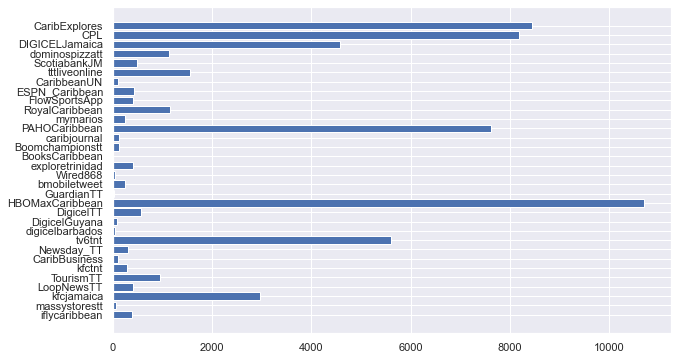

In [189]:
# to see which companies getting likes. If outliers and keeping them do violin plot otherwise do regular bargraph
sorted_by_likes = df.sort_values('No. of likes')
plt.figure(figsize=(10,6))
plt.barh(sorted_by_likes['Username'], sorted_by_likes['No. of likes'])

In [232]:
def print_cloud(data, engagement_level):
    text = " ".join(review for review in data)
    print ("There are {} words in the combination of all tweets with {} engagement.".format(len(text), engagement_level))
    wordcloud = WordCloud(background_color="white").generate(text)
    return wordcloud

There are 302566 words in the combination of all tweets with low engagement.


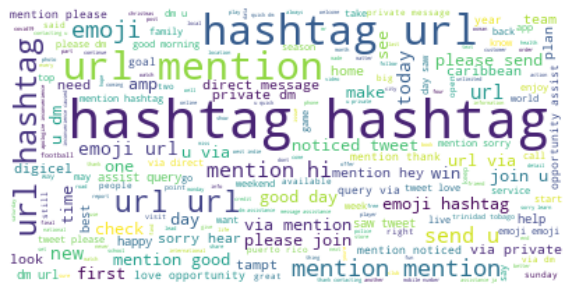

In [233]:
wordcloud = print_cloud(low_engagement['Content'], 'low')
fig = plt.figure(1, figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
fig.savefig("word1.png", dpi=300)

There are 398971 words in the combination of all tweets with high engagement.


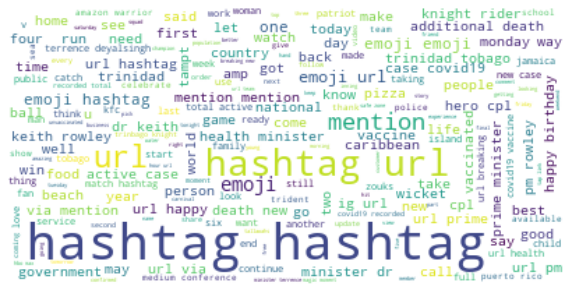

In [234]:
wordcloud = print_cloud(high_engagement['Content'], 'high')
fig = plt.figure(1, figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
fig.savefig("word1.png", dpi=300)

In [ ]:
words w one on one customerinteracttion lesseengagement trule sorry,  hey, customer relation. etc.  words. relaedt. to covid more interactionms

In [235]:
df['Length of Tweet'] = df['Content'].str.split().str.len()
sorted_by_length = df.sort_values('Length of Tweet')
sorted_by_length.head()

,Username,Followers,Content,No. of likes,No. of retweets,No. of replies,Length of Tweet
61883,HBOMaxCaribbean,9671,,3,0,0,0
28186,dominospizzatt,2679,,16,0,9,0
55384,DigicelGuyana,6924,,2,1,0,0
57480,DigicelGuyana,6924,,0,0,0,0
28043,dominospizzatt,2679,emoji,45,1,13,1


Text(0, 0.5, 'No. of likes')

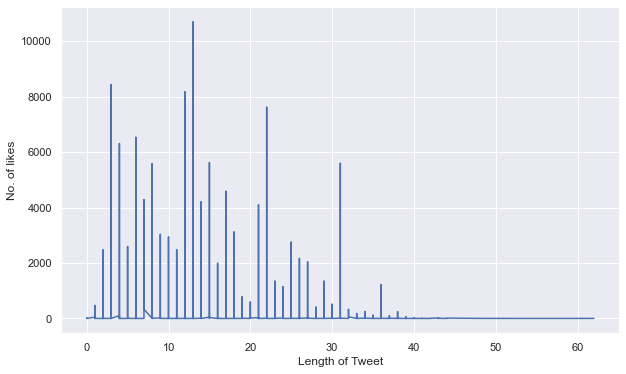

In [240]:
plt.figure(figsize=(10,6))
plt.plot(sorted_by_length['Length of Tweet'], sorted_by_length['No. of likes'])
plt.xlabel('Length of Tweet')
plt.ylabel('No. of likes')

In [ ]:
#length of tweet vs likes
# len_vs_likes_df = df[[len()]]

ValueError: could not convert string to float: 'BooksCaribbean'

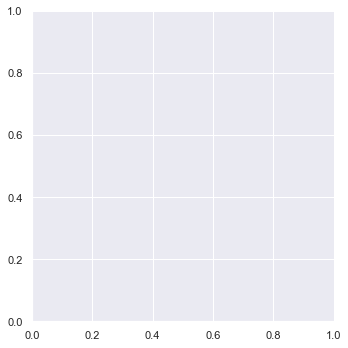

In [190]:
# see where like range falling with scatterplot
sns.lmplot(x='No. of likes', y='Username', data=df,
           fit_reg=False, 
           hue='Username')
plt.gcf().set_size_inches(20, 15)

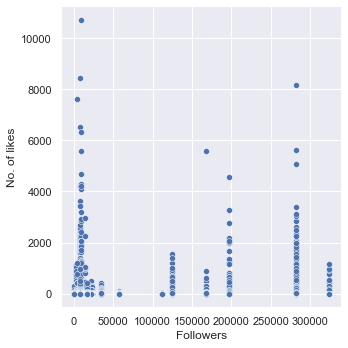

In [187]:
# visualize relationship between likes and followers
sns.relplot(x="Followers", y="No. of likes", data=df)

#### Topic Modeling

In [ ]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])
            print("\n")

In [ ]:
low_eng_docs = list(low_engagement['Content'])
high_eng_docs = list(high_engagement['Content'])

In [ ]:
#using NMF with 5 topics
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_low = tfidf_vectorizer.fit_transform(low_eng_docs)
tfidf_high = tfidf_vectorizer.fit_transform(high_eng_docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

no_topics = 5

## Train the model

In [243]:
X = new_df['Content']    #tweet data being put into machine learning models
y = new_df['Engagement'] #labels for tweet engagement

In [244]:
# perform TFIDF vectorizer on tweets
tfidf_n = TfidfVectorizer(ngram_range=(1,2))
X_vectorized = tfidf_n.fit_transform(X)
print('Shape after TFIDF vectorizer: {}'.format(X_vectorized.shape))

Shape after TFIDF vectorizer: (7870, 74328)


As seen above, after performing the TFIDFVectorizer on the tweet data, 74328 features are present in the dataset. This may decrease the model's processing speed and so the SelectPercentile function is used to select the top features in the dataset while discarding less important ones, thus limiting the number of features under consideration.

In [245]:
select_percentile = SelectPercentile(f_classif, percentile=50)
X_vectorized = select_percentile.fit_transform(X_vectorized, y)
print('Shape after select percentile: {}'.format(X_vectorized.shape))

Shape after select percentile: (7870, 37164)


In [246]:
# split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, random_state=0)
print('# train records: {}'.format(X_train.shape[0]))
print('# test records: {}'.format(X_test.shape[0]))

# train records: 5902
# test records: 1968


In [247]:
# create logistic regression model for classification
log_reg = LogisticRegression().fit(X_train, y_train)

In [250]:
# predict on test data using logistic regression model
predicted = log_reg.predict(X_test)
print(predicted)
accuracy = recall_score(y_test,predicted)
print(accuracy)

[0 0 0 ... 0 1 1]
0.8397104446742503


## Test the model

In [252]:
test = ["there have been no deaths due to covid19 in Trinidad recently, due to the increased number of vaccinated persons",
       "hey there you, send us a private message for a chance to win a dollar", 
       "Today rain fell heavily all over Trinidad, there were lots of floods"]
for t in test:
    t = clean_text(t)
test_vectorized = tfidf_n.transform(test)
test_vectorized = select_percentile.transform(test_vectorized)
test_pred = log_reg.predict(test_vectorized)
print(test_pred)

[1 0 1]


## References

- https://www.sciencedirect.com/science/article/pii/S1877050920304129
- https://www.freecodecamp.org/news/how-to-predict-likes-and-shares-based-on-your-articles-title-using-machine-learning-47f98f0612ea/
- https://monkeylearn.com/blog/what-is-tf-idf/

dataset points
- clean  data removing @, # etc
-  